In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from langdetect import detect
import json
import re
from collections import Counter, defaultdict
import string
from scipy import stats

In [2]:
#Cleaning out the original test and train datasets 
def langFilter(file,type:str):
    num = 0
    with open(f"hotel_review_en_{type}.JSON", "w") as out_file:
        with open(file,"r") as in_file:
            lines = in_file.readlines()
            for line in lines:
                num += 1
                # if num%100==0: print(num)
                json_line = json.loads(line)
                try:
                    lang = detect(json_line["text"])
                    if lang == "en":
                        out_file.write(line)
                except:
                    print("exception")
                    pass

#uncomment to generate JSON train and test sets of only english texts
# langFilter("hotel_reviews_train.JSON","train")
# langFilter("hotel_reviews_test.JSON","test")

In [3]:
train_data = pd.read_json('hotel_review_en_train.JSON', lines=True)
test_data = pd.read_json('hotel_review_en_test.JSON', lines=True)
train_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 1.0, 'cleanliness': 2.0, 'overall'...",“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False
1,"{'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...",“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False
3,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False
4,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False


In [4]:
test_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“I was SO surprised! I WILL return!”,My husband and I just celebrated our 25th wedd...,"{'username': 'shooflyfarm', 'num_cities': 15, ...",November 2011,1783324,1,2011-11-26,121063682,False
1,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“A Mother/Daughter vacation”,I could not leave a bad comment on any part of...,"{'username': 'bestmpm', 'num_reviews': 1, 'id'...",August 2011,88458,0,2011-08-10,116545869,False
2,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Good Choice for Pre-cruise”,I spent one night at this hotel prior to a cru...,"{'username': 'Conner2dood', 'num_cities': 20, ...",November 2010,82868,0,2010-12-06,89196759,False
3,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“Unsung Hero”,"For the past year and a half, my daughter has ...","{'username': 'LeviK', 'num_reviews': 2, 'num_c...",July 2011,98979,0,2011-07-28,115879719,False
4,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Great Value for a King, Queen, and Princesses.”","Great Value for a King, Queen, and Princesses....","{'username': 'thomrho', 'num_cities': 13, 'num...",March 2007,112273,8,2007-03-21,7198417,False


In [5]:
train_data.columns

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile'],
      dtype='object')

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ratings            23999 non-null  object        
 1   title              23999 non-null  object        
 2   text               23999 non-null  object        
 3   author             23999 non-null  object        
 4   date_stayed        23049 non-null  object        
 5   offering_id        23999 non-null  int64         
 6   num_helpful_votes  23999 non-null  int64         
 7   date               23999 non-null  datetime64[ns]
 8   id                 23999 non-null  int64         
 9   via_mobile         23999 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(3), object(5)
memory usage: 1.7+ MB


In [7]:
train_data.isna().sum()

ratings                0
title                  0
text                   0
author                 0
date_stayed          950
offering_id            0
num_helpful_votes      0
date                   0
id                     0
via_mobile             0
dtype: int64

In [8]:
train_data['id'].duplicated().sum()

0

In [9]:
train_data['ratings'][0]

{'service': 1.0,
 'cleanliness': 2.0,
 'overall': 1.0,
 'value': 1.0,
 'location': 3.0,
 'sleep_quality': 2.0,
 'rooms': 1.0}

In [10]:
unique_cols = defaultdict(int)

for i in range(len(train_data)):
    for n in train_data['ratings'][i].keys():
        unique_cols[n] += 1

unique_cols

defaultdict(int,
            {'service': 21549,
             'cleanliness': 21544,
             'overall': 23999,
             'value': 21546,
             'location': 18982,
             'sleep_quality': 14184,
             'rooms': 19999,
             'check_in_front_desk': 2909,
             'business_service_(e_g_internet_access)': 1959})

In [11]:
print("Rating Counts broken into percentages:")
for k,v in unique_cols.items():
    print(f'{k}: {round((v/len(train_data))*100,2)}%')

Rating Counts broken into percentages:
service: 89.79%
cleanliness: 89.77%
overall: 100.0%
value: 89.78%
location: 79.09%
sleep_quality: 59.1%
rooms: 83.33%
check_in_front_desk: 12.12%
business_service_(e_g_internet_access): 8.16%


In [12]:
def average_ratings(data):
    ratings = defaultdict(list)
    for i in range(len(data)):
        rat = train_data['ratings'][i]
        for n in rat:
            ratings[n].append(rat[n])
    
    avg_metrics = defaultdict(int)
    for n in ratings:
        avg_metrics[n] = np.round(np.array(ratings[n]).mean(),3)
    
    return avg_metrics

averaged_ratings_of_reviews = average_ratings(train_data)

for quality, rating in averaged_ratings_of_reviews.items():
    print(f'{quality}: {rating}')


service: 4.102
cleanliness: 4.23
overall: 3.943
value: 3.918
location: 4.413
sleep_quality: 4.146
rooms: 3.943
check_in_front_desk: 3.945
business_service_(e_g_internet_access): 3.662


In [13]:
print(train_data['ratings'])

0        {'service': 1.0, 'cleanliness': 2.0, 'overall'...
1        {'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...
2        {'service': 4.0, 'cleanliness': 5.0, 'overall'...
3        {'service': 3.0, 'cleanliness': 2.0, 'overall'...
4                                         {'overall': 1.0}
                               ...                        
23994    {'service': 3.0, 'cleanliness': 4.0, 'overall'...
23995    {'service': 3.0, 'cleanliness': 3.0, 'overall'...
23996    {'service': 4.0, 'cleanliness': 4.0, 'overall'...
23997    {'cleanliness': 5.0, 'sleep_quality': 4.0, 'ov...
23998    {'service': 5.0, 'cleanliness': 5.0, 'overall'...
Name: ratings, Length: 23999, dtype: object


In [14]:
print(train_data['ratings'][0])


{'service': 1.0, 'cleanliness': 2.0, 'overall': 1.0, 'value': 1.0, 'location': 3.0, 'sleep_quality': 2.0, 'rooms': 1.0}


In [15]:
json_cols = ['ratings']

normalized_cols = pd.json_normalize(train_data['ratings'])
train_data_new = train_data.join(normalized_cols)
train_data_new = train_data_new.drop(json_cols, axis=1)

In [16]:
unique_cols

defaultdict(int,
            {'service': 21549,
             'cleanliness': 21544,
             'overall': 23999,
             'value': 21546,
             'location': 18982,
             'sleep_quality': 14184,
             'rooms': 19999,
             'check_in_front_desk': 2909,
             'business_service_(e_g_internet_access)': 1959})

In [17]:
train_data_new.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,check_in_front_desk,business_service_(e_g_internet_access)
0,“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,1.0,2.0,1.0,1.0,3.0,2.0,1.0,NaN,NaN
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,1.0,1.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,4.0,5.0,4.0,3.0,5.0,4.0,4.0,NaN,NaN
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,3.0,2.0,2.0,1.0,4.0,1.0,1.0,NaN,NaN
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
train_data_new.isna().sum()

title                                         0
text                                          0
author                                        0
date_stayed                                 950
offering_id                                   0
num_helpful_votes                             0
date                                          0
id                                            0
via_mobile                                    0
service                                    2450
cleanliness                                2455
overall                                       0
value                                      2453
location                                   5017
sleep_quality                              9815
rooms                                      4000
check_in_front_desk                       21090
business_service_(e_g_internet_access)    22040
dtype: int64

In [19]:
train_data_new = train_data_new.drop(['business_service_(e_g_internet_access)', 'check_in_front_desk'], axis=1)
train_data_new.isna().sum()

title                   0
text                    0
author                  0
date_stayed           950
offering_id             0
num_helpful_votes       0
date                    0
id                      0
via_mobile              0
service              2450
cleanliness          2455
overall                 0
value                2453
location             5017
sleep_quality        9815
rooms                4000
dtype: int64

<Axes: >

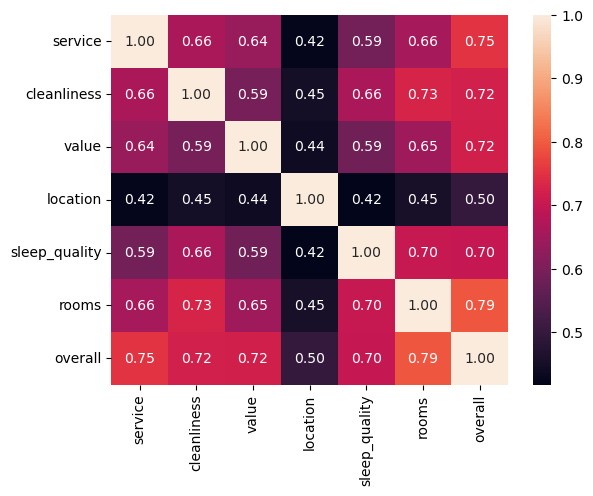

In [20]:
import seaborn as sns
cols = ['service','cleanliness','value','location','sleep_quality','rooms','overall']
corr = train_data_new[cols].corr(method='spearman')
sns.heatmap(corr, annot=True, fmt=".2f")

In [21]:
spearman_overall = (
    train_data_new[cols].corr(method="spearman")['overall']
    .drop('overall')
    .sort_values(ascending=False)
)
print(spearman_overall)

rooms            0.793961
service          0.750456
cleanliness      0.721267
value            0.719540
sleep_quality    0.700825
location         0.498392
Name: overall, dtype: float64


In [22]:
train_data_new['missing_sq'] = train_data_new['sleep_quality'].isna().astype(int)
train_data_new['missing_sq']

0        0
1        0
2        0
3        0
4        1
        ..
23994    0
23995    0
23996    1
23997    0
23998    1
Name: missing_sq, Length: 23999, dtype: int64

<Axes: xlabel='missing_sq', ylabel='overall'>

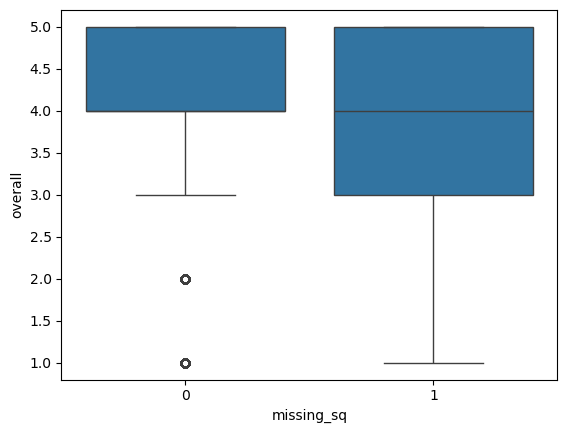

In [23]:
sns.boxplot(x='missing_sq', y='overall', data=train_data_new)

In [24]:
train_data_new.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,missing_sq
0,“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,1.0,2.0,1.0,1.0,3.0,2.0,1.0,0
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,1.0,1.0,1.0,2.0,NaN,1.0,NaN,0
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,4.0,5.0,4.0,3.0,5.0,4.0,4.0,0
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,3.0,2.0,2.0,1.0,4.0,1.0,1.0,0
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1


In [25]:
train_data_new['author'][2]

{'username': 'Moonstonemoclips',
 'num_cities': 31,
 'num_helpful_votes': 27,
 'num_reviews': 48,
 'num_type_reviews': 32,
 'id': 'F3D0CF371B788300E73A1413B2DABB4B',
 'location': 'Kirkland'}

In [26]:
author_keys = defaultdict(int)

for n in train_data_new['author']:
    for j in n:
        author_keys[j] += 1

author_keys

defaultdict(int,
            {'username': 23999,
             'num_reviews': 22918,
             'id': 23999,
             'location': 23999,
             'num_cities': 17538,
             'num_helpful_votes': 18864,
             'num_type_reviews': 14629})

In [27]:
def most_common_author_features(column):
    unique_username = Counter()
    for n in train_data_new['author']:
        if column not in n:
            continue
        name = n[column]
        unique_username[name] += 1 if name in unique_username else 0

    return unique_username.most_common(10)

most_common_author_features('username')

[('', 1077),
 ('David M', 5),
 ('John S', 4),
 ('David C', 4),
 ('David P', 3),
 ('Mike R', 3),
 ('DoesNotGetOutMuch', 3),
 ('Linda D', 3),
 ('brmusicman', 3),
 ('Christine H', 3)]

In [28]:
most_common_author_features('location')

[('', 2183),
 ('New York City, New York', 273),
 ('London, United Kingdom', 236),
 ('Chicago, Illinois', 219),
 ('London', 201),
 ('Houston, Texas', 186),
 ('Los Angeles, California', 185),
 ('Washington DC, District of Columbia', 180),
 ('Boston, Massachusetts', 148),
 ('Toronto, Canada', 146)]

In [29]:
david_cities = []
for n in train_data_new['author']:
    if n['username'] == 'David M':
        david_cities.append(n['location'])

david_cities

['London, United Kingdom',
 'New Bern, North Carolina',
 'Quad Cities, IA',
 'Amarillo',
 'Ukiah, CA',
 'Omaha, Nebraska']

In [30]:
train_data_new.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,missing_sq
0,“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,1.0,2.0,1.0,1.0,3.0,2.0,1.0,0
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,1.0,1.0,1.0,2.0,NaN,1.0,NaN,0
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,4.0,5.0,4.0,3.0,5.0,4.0,4.0,0
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,3.0,2.0,2.0,1.0,4.0,1.0,1.0,0
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1


In [31]:
train_data_new['date_stayed'] = pd.to_datetime(
    train_data_new['date_stayed'].str.strip(),
    format = "%B %Y",
    errors = 'coerce'
)

train_data_new["date_stayed"] = train_data_new["date_stayed"].dt.strftime("%Y-%m")
train_data_new.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,missing_sq
0,“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",2012-09,80138,0,2012-09-19,140716137,False,1.0,2.0,1.0,1.0,3.0,2.0,1.0,0
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",2011-06,240151,1,2011-06-27,114807323,False,1.0,1.0,1.0,2.0,NaN,1.0,NaN,0
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",2010-10,80793,0,2010-10-25,84805430,False,4.0,5.0,4.0,3.0,5.0,4.0,4.0,0
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",2012-06,111418,1,2012-06-28,132971117,False,3.0,2.0,2.0,1.0,4.0,1.0,1.0,0
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",2012-01,671150,3,2012-02-04,124104157,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1


In [32]:
train_data_new["date_stayed_dt"] = pd.to_datetime(
        train_data_new["date_stayed"].astype(str) + "-01",
        format="%Y-%m-%d", errors="coerce"
)

<Axes: title={'center': 'Mean overall rating against month'}, xlabel='Month stayed', ylabel='Mean overall rating'>

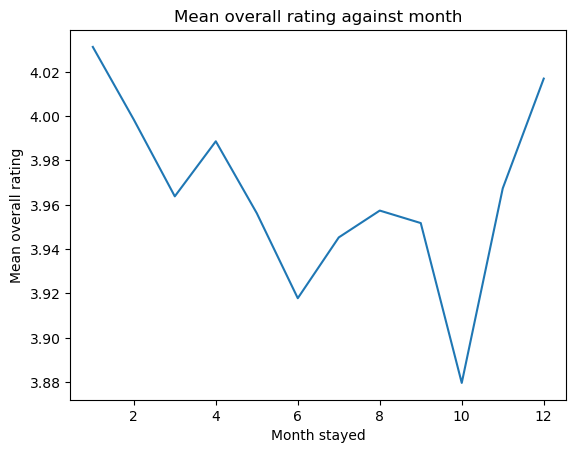

In [33]:
(train_data_new
   .groupby(train_data_new["date_stayed_dt"].dt.month)["overall"]
   .mean()
   .plot(kind="line", title="Mean overall rating against month", ylabel="Mean overall rating", xlabel="Month stayed"))

In [34]:
train_data_new.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,missing_sq,date_stayed_dt
0,“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",2012-09,80138,0,2012-09-19,140716137,False,1.0,2.0,1.0,1.0,3.0,2.0,1.0,0,2012-09-01
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",2011-06,240151,1,2011-06-27,114807323,False,1.0,1.0,1.0,2.0,NaN,1.0,NaN,0,2011-06-01
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",2010-10,80793,0,2010-10-25,84805430,False,4.0,5.0,4.0,3.0,5.0,4.0,4.0,0,2010-10-01
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",2012-06,111418,1,2012-06-28,132971117,False,3.0,2.0,2.0,1.0,4.0,1.0,1.0,0,2012-06-01
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",2012-01,671150,3,2012-02-04,124104157,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1,2012-01-01


In [35]:
mobile = train_data_new[train_data_new['via_mobile'] == True]
not_mobile = train_data_new[train_data_new['via_mobile'] == False]

percentage_from_phone = round(len(mobile)/len(train_data_new),4)
percentage_from_phone

0.0564

In [36]:
train_data_new['via_mobile'] = train_data_new['via_mobile'].astype(int)
train_data_new['via_mobile']

0        0
1        0
2        0
3        0
4        0
        ..
23994    0
23995    0
23996    1
23997    0
23998    1
Name: via_mobile, Length: 23999, dtype: int64

In [37]:
percentage_no_phone = round(len(not_mobile)/len(train_data_new),4)
percentage_no_phone

0.9436

In [38]:
assert percentage_no_phone + percentage_from_phone == 1.00, 'issue with calcuation of percentages'

In [39]:
mobile['overall'].mean()

3.926090169992609

In [40]:
not_mobile['overall'].mean()

3.9445376666961054

In [41]:
phone_lengths = train_data_new[train_data_new['via_mobile'] == True]['text'].str.split().str.len()
no_phone_lengths = train_data_new[train_data_new['via_mobile'] == False]['text'].str.split().str.len()

print(f"mean review length for reviews posted using phone: {round(phone_lengths.mean(),4)} characters")
print(f"mean review length for reviews posted not using phone: {round(no_phone_lengths.mean(),4)} characters")

mean review length for reviews posted using phone: 98.1604 characters
mean review length for reviews posted not using phone: 156.4316 characters


In [42]:
def average_text_length_by_rating(column):
    avg_len_by_rating = {}
    for i in range(1,6):
        text_lens = train_data_new[train_data_new[column] == i]['text'].str.split().str.len()
        avg_len_by_rating[i] = int(text_lens.mean())
    
    return avg_len_by_rating

avg_array = []
avg_len_per_rating = {i+1:0 for i in range(5)}

for n in cols:
    avg_len = average_text_length_by_rating(n)
    avg_array.append((n,avg_len))
    for v in avg_len:
        avg_len_per_rating[v] += avg_len[v]
    print(f"Average length review for {n}: {avg_len}")


Average length review for service: {1: 218, 2: 196, 3: 171, 4: 150, 5: 140}
Average length review for cleanliness: {1: 189, 2: 198, 3: 173, 4: 155, 5: 144}
Average length review for value: {1: 203, 2: 198, 3: 169, 4: 146, 5: 139}
Average length review for location: {1: 186, 2: 183, 3: 167, 4: 158, 5: 146}
Average length review for sleep_quality: {1: 188, 2: 191, 3: 162, 4: 147, 5: 138}
Average length review for rooms: {1: 186, 2: 188, 3: 171, 4: 154, 5: 139}
Average length review for overall: {1: 193, 2: 201, 3: 175, 4: 148, 5: 135}


In [43]:
for v in avg_len_per_rating:
    avg_len_per_rating[v] = avg_len_per_rating[v]//5

avg_len_per_rating

{1: 272, 2: 271, 3: 237, 4: 211, 5: 196}

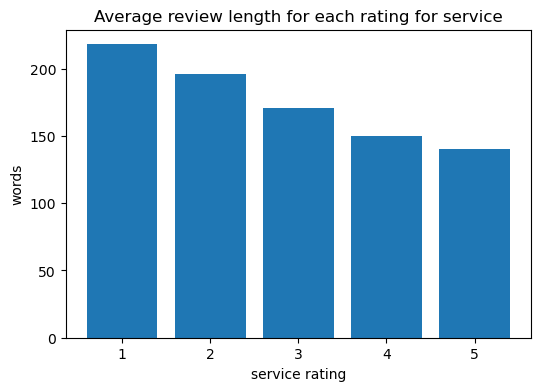

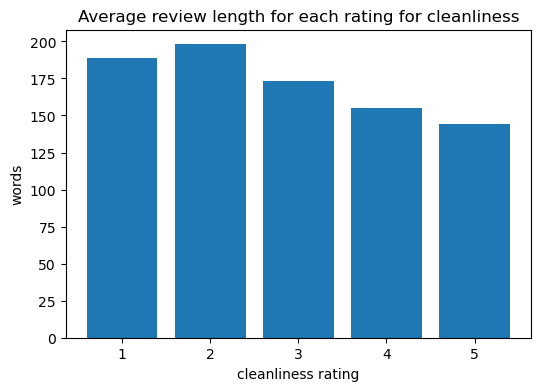

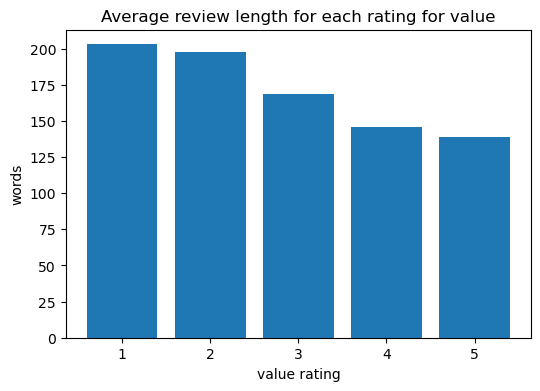

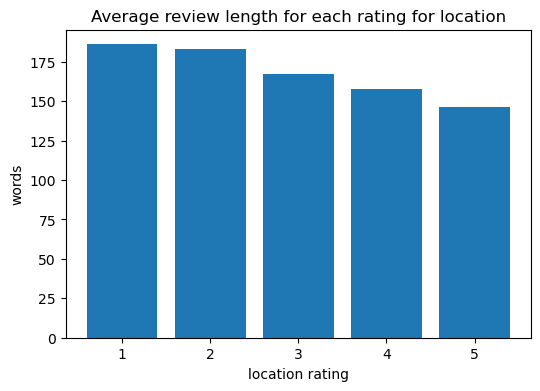

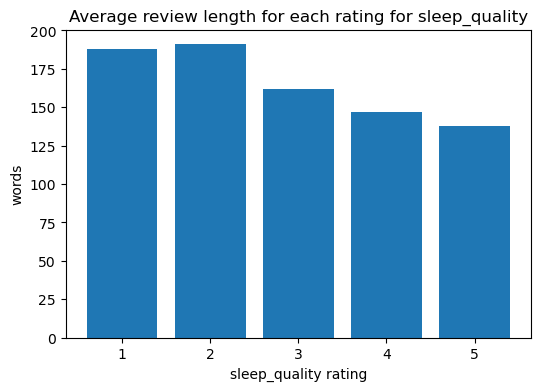

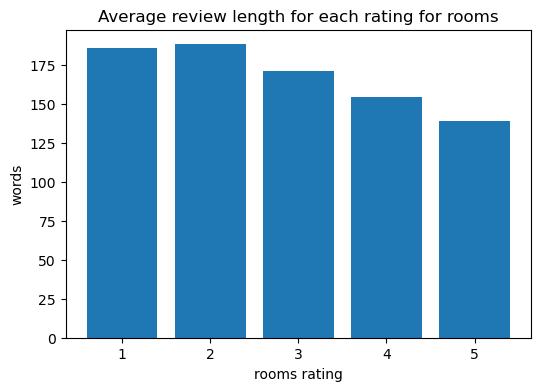

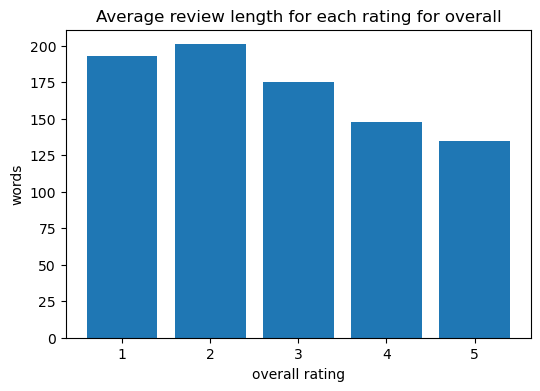

In [44]:
def plot_avg_ratings(index):
    name, ratings = avg_array[index]
    plt.figure(figsize=(6,4))
    plt.bar(ratings.keys(), ratings.values())
    plt.title(f'Average review length for each rating for {name}')
    plt.xlabel(f'{name} rating')
    plt.ylabel('words')
    plt.show()

for i in range(len(avg_array)):
    plot_avg_ratings(i)

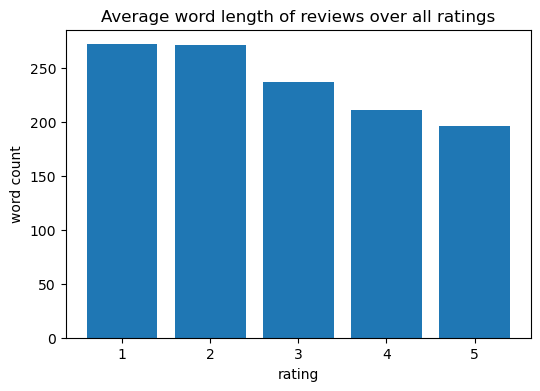

In [45]:
plt.figure(figsize=(6,4))
plt.bar(avg_len_per_rating.keys(), avg_len_per_rating.values())
plt.title(f'Average word length of reviews over all ratings')
plt.xlabel('rating')
plt.ylabel('word count')
plt.show()

In [46]:
train_data_new.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,missing_sq,date_stayed_dt
0,“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",2012-09,80138,0,2012-09-19,140716137,0,1.0,2.0,1.0,1.0,3.0,2.0,1.0,0,2012-09-01
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",2011-06,240151,1,2011-06-27,114807323,0,1.0,1.0,1.0,2.0,NaN,1.0,NaN,0,2011-06-01
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",2010-10,80793,0,2010-10-25,84805430,0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,0,2010-10-01
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",2012-06,111418,1,2012-06-28,132971117,0,3.0,2.0,2.0,1.0,4.0,1.0,1.0,0,2012-06-01
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",2012-01,671150,3,2012-02-04,124104157,0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1,2012-01-01


In [47]:
train_data_new['num_helpful_votes'].value_counts()[:5]

num_helpful_votes
0    12636
1     5574
2     2445
3     1127
4      643
Name: count, dtype: int64

In [48]:
train_data_new['num_helpful_votes'].unique()

array([  0,   1,   3,   4,   2,   7,  11,   9,   5,  12,   6,   8,  13,
        15,  10,  16,  25,  24,  18,  17,  21,  14,  20,  22,  26,  23,
        19,  45,  36,  38,  56,  54,  57,  30,  32,  98,  63,  28,  44,
        46,  50,  39,  27,  29,  40,  41, 401])

In [49]:
train_data_new.loc[(train_data_new['num_helpful_votes'] == 401)]

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,missing_sq,date_stayed_dt
23937,“stay in old fashion style”,Stayed in a lovely suite on 31st floor. Saw th...,"{'username': 'karin stockholm', 'num_cities': ...",2006-05,114591,401,2006-06-03,5294881,0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1,2006-05-01


In [50]:
train_data_new.loc[(train_data_new['num_helpful_votes'] == 41)]

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,missing_sq,date_stayed_dt
21883,“Great Place to Stay in NYC”,We stayed at this small hotel in December 2004...,"{'username': '', 'id': '', 'location': ''}",2004-12,217630,41,2005-06-29,3621014,0,4.0,4.0,5.0,4.0,NaN,NaN,4.0,1,2004-12-01


In [51]:
def build_prompt(dfrow):
    FILL = '<MISSING>'

    def format_prompt(col, val):
        return f"{col}: {FILL if pd.isna(val) else int(val)}"
    
    def rating_to_len(rating):
        if rating == 1 or rating == 2:
            return "LONG"
        elif rating == 3:
            return "MED"
        elif rating == 4 or rating == 5:
            return "SHORT"

    form = [
        format_prompt('service', dfrow['service']),
        format_prompt('cleanliness',dfrow['cleanliness']),
        format_prompt('value', dfrow['value']),
        format_prompt('rooms', dfrow['rooms']),
        format_prompt('location', dfrow['location']),
        format_prompt('sleep_quality', dfrow['sleep_quality']),
        format_prompt('overall', dfrow['overall']),
        f"date_stayed: {dfrow['date_stayed'] if not pd.isna(dfrow['date_stayed']) else FILL}",
        f"device: {'PHONE' if bool(dfrow['via_mobile']) else 'COMPUTER'}",
        f"len: {rating_to_len(dfrow['overall'])}"

    ]

    instruction = (
        "You are a travel review generator for hotel. You will be given a number features including numerical ratings for a number of properties alongisde some others" 
        "Ratings use a 1-5 scale (1 = terrible, 5 = excellent)."
        "You will also be given the date stayed, the expected length of the review and also if it was written on a phone or not."
        "Write a review that aligns with the features given but doesn't necessarily quote them directly."
    )

    prompt = (
    f"<INST>\n{instruction}\n</INST>\n"
    "<FEAT>\n"
    + "\n".join(form) +
    "\n</FEAT>\n"
    "<REVIEW>\n"
    )

    return prompt

In [52]:
train_data_new['prompts'] = train_data_new.apply(build_prompt, axis=1)
train_data_new['prompts'][0]

"<INST>\nYou are a travel review generator for hotel. You will be given a number features including numerical ratings for a number of properties alongisde some othersRatings use a 1-5 scale (1 = terrible, 5 = excellent).You will also be given the date stayed, the expected length of the review and also if it was written on a phone or not.Write a review that aligns with the features given but doesn't necessarily quote them directly.\n</INST>\n<FEAT>\nservice: 1\ncleanliness: 2\nvalue: 1\nrooms: 1\nlocation: 3\nsleep_quality: 2\noverall: 1\ndate_stayed: 2012-09\ndevice: COMPUTER\nlen: LONG\n</FEAT>\n<REVIEW>\n"

In [53]:
train_data_new.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,missing_sq,date_stayed_dt,prompts
0,“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",2012-09,80138,0,2012-09-19,140716137,0,1.0,2.0,1.0,1.0,3.0,2.0,1.0,0,2012-09-01,<INST>\nYou are a travel review generator for ...
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",2011-06,240151,1,2011-06-27,114807323,0,1.0,1.0,1.0,2.0,NaN,1.0,NaN,0,2011-06-01,<INST>\nYou are a travel review generator for ...
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",2010-10,80793,0,2010-10-25,84805430,0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,0,2010-10-01,<INST>\nYou are a travel review generator for ...
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",2012-06,111418,1,2012-06-28,132971117,0,3.0,2.0,2.0,1.0,4.0,1.0,1.0,0,2012-06-01,<INST>\nYou are a travel review generator for ...
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",2012-01,671150,3,2012-02-04,124104157,0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1,2012-01-01,<INST>\nYou are a travel review generator for ...


In [54]:
id_prompts = train_data_new[['text','id','prompts']]
id_prompts.head()

,text,id,prompts
0,First of all we got there and they didn't have...,140716137,<INST>\nYou are a travel review generator for ...
1,Found Racist graffiti in the room. Request to ...,114807323,<INST>\nYou are a travel review generator for ...
2,Close to Union Square - hotel is a bit of a ma...,84805430,<INST>\nYou are a travel review generator for ...
3,I had a bad vibe about this place from the mom...,132971117,<INST>\nYou are a travel review generator for ...
4,"After we received our ""final"" bill and left th...",124104157,<INST>\nYou are a travel review generator for ...


In [55]:
model_df = id_prompts[['prompts','text']]
model_df.head()

,prompts,text
0,<INST>\nYou are a travel review generator for ...,First of all we got there and they didn't have...
1,<INST>\nYou are a travel review generator for ...,Found Racist graffiti in the room. Request to ...
2,<INST>\nYou are a travel review generator for ...,Close to Union Square - hotel is a bit of a ma...
3,<INST>\nYou are a travel review generator for ...,I had a bad vibe about this place from the mom...
4,<INST>\nYou are a travel review generator for ...,"After we received our ""final"" bill and left th..."


In [56]:
import transformers
import accelerate
import trl
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM,
                          DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, Trainer)

model_ds = Dataset.from_pandas(model_df)
split = model_ds.train_test_split(test_size=0.1, shuffle=True)
split


/home/arpydarpy/miniconda3/envs/a1nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['prompts', 'text'],
        num_rows: 21599
    })
    test: Dataset({
        features: ['prompts', 'text'],
        num_rows: 2400
    })
})

In [57]:
train_set, val_set = split["train"], split['test']
train_set

Dataset({
    features: ['prompts', 'text'],
    num_rows: 21599
})

In [58]:
val_set

Dataset({
    features: ['prompts', 'text'],
    num_rows: 2400
})

In [155]:
MODEL_NAME = 'google/flan-t5-base'
tokeniser = AutoTokenizer.from_pretrained(MODEL_NAME)

In [196]:
encoded = tokeniser(train_data_new['prompts'][2], return_tensors="pt", add_special_tokens=True)
num_tokens = encoded["input_ids"].shape[1]

print(f"This prompt is {num_tokens} tokens long.")

This prompt is 151 tokens long.


In [157]:
SPECIAL = ["<INST>", "</INST>", "<FEAT>", "</FEAT>",
           "<REVIEW>", "</REVIEW>" "<MISSING>"]

tokeniser.add_special_tokens({"additional_special_tokens": SPECIAL})

6

In [158]:
def encode_data(data):
    inp = tokeniser(data["prompts"],
                    max_length=256,
                    truncation=True,
                    padding="max_length")
    
    out = tokeniser(data["text"],
                    max_length=256,
                    truncation=True,
                    padding="max_length")
    
    inp["labels"] = out["input_ids"]
    return inp

train_tokens = train_set.map(encode_data,
                             batched=True,
                             remove_columns=train_set.column_names)
val_tokens = val_set.map(encode_data,
                         batched=True,
                         remove_columns=val_set.column_names)

train_tokens

Map: 100%|██████████| 2400/2400 [00:00<00:00, 7765.25 examples/s]


Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 21599
})

In [159]:
print("Torch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Torch version: 2.8.0.dev20250419+cu118
cuda


In [160]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, torch_dtype=torch.bfloat16, device_map='auto')
model.resize_token_embeddings(len(tokeniser))
model.gradient_checkpointing_enable()
model.tie_weights()

In [161]:
model.parameters

<bound method Module.parameters of T5ForConditionalGeneration(
  (shared): Embedding(32106, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32106, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=20

In [162]:
collator = DataCollatorForSeq2Seq(tokenizer=tokeniser, model = model)

In [163]:
import evaluate

rouge = evaluate.load("rouge", rouge_types=["rouge1", "rouge2", "rougeL"])

pad_id = tokeniser.pad_token_id or tokeniser.eos_token_id

def post(txts):         
    return [t.strip() for t in txts]

def compute_metrics(eval_pred):
    pred_ids, label_ids = eval_pred          
    
    pred_ids  = np.asarray(pred_ids,  dtype="int64")
    label_ids = np.asarray(label_ids, dtype="int64")

    label_ids[label_ids == -100] = pad_id
    pred_ids[pred_ids == -100] = pad_id

    pred_ids  = pred_ids.tolist()
    label_ids = label_ids.tolist()

    decoded_preds  = post(tokeniser.batch_decode(pred_ids,
                                                 skip_special_tokens=True))
    decoded_labels = post(tokeniser.batch_decode(label_ids,
                                                 skip_special_tokens=True))

    rouge_out = rouge.compute(predictions=decoded_preds,
                              references=decoded_labels,
                              use_stemmer=True)

    return {f"{k}": round(v * 100, 4)  for k, v in rouge_out.items()}

In [164]:
model.config.use_cache = False
args = Seq2SeqTrainingArguments(
    output_dir = "checkpoints_new_a",
    per_device_train_batch_size = 64,
    per_device_eval_batch_size  = 64,
    gradient_accumulation_steps = 1,
    num_train_epochs = 3,
    learning_rate = 4e-5,
    weight_decay= 0.01,
    warmup_steps= 305,
    eval_accumulation_steps= 1,
    predict_with_generate= True,   
    generation_max_length=256,      
    generation_num_beams = 1,
    save_strategy = "steps",
    eval_strategy  = "steps",
    eval_steps= 250,
    save_steps = 250,
    load_best_model_at_end = True,
    metric_for_best_model= "eval_rougeL",
    greater_is_better = True,
    lr_scheduler_type="cosine",
    bf16=True,
    seed = 42,
    logging_steps=100,
    save_total_limit=2,
    torch_compile=True,
    report_to = "none",
    tf32=True,
    dataloader_pin_memory=True,
    optim="adamw_torch_fused",
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset = train_tokens,
    eval_dataset=val_tokens,
    data_collator=collator,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
250,11.463500,3.348728,10.660400,1.428100,10.036700,10.044000
500,2.240000,1.975498,15.786900,2.669100,11.598300,11.603600
750,2.115600,1.945577,25.714600,5.689600,17.029200,17.027800
1000,2.085400,1.943642,25.781600,5.696600,17.045000,17.040100


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=1014, training_loss=4.90044719839002, metrics={'train_runtime': 1812.7493, 'train_samples_per_second': 35.745, 'train_steps_per_second': 0.559, 'total_flos': 2.2183429454954496e+16, 'train_loss': 4.90044719839002, 'epoch': 3.0})

In [165]:
from math import exp
print("best metric:", trainer.state.best_metric)
print("current model loss on val:",
      trainer.evaluate(max_length=512, num_beams=1)["eval_loss"])
print("requires-grad encoder layers:",
      sum(p.requires_grad for p in model.encoder.parameters()))

best metric: 17.045


current model loss on val: 1.943642497062683
requires-grad encoder layers: 111


In [166]:
# eval_results = trainer.evaluate(max_length=256, num_beams=2)
# perplexity   = np.exp(eval_results["eval_loss"])
# print(f"Validation PPL: {perplexity:.2f}")

In [167]:
import os
BEST_DIR_M1 = "best-review-generator-model_new_rev_a"
os.makedirs(BEST_DIR_M1, exist_ok=True)

trainer.save_model(BEST_DIR_M1)             
tokeniser.save_pretrained(BEST_DIR_M1)            

print(f"Best checkpoint copied to  {BEST_DIR_M1}/")

Best checkpoint copied to  best-review-generator-model_new_rev_a/


In [184]:
from transformers import GenerationConfig

gen_cfg = GenerationConfig.from_pretrained(BEST_DIR_M1)
gen_cfg.update(
    max_new_tokens     = 512,
    do_sample          = True,  
    top_p              = 0.9,
    temperature        = 0.7,
    repetition_penalty = 1.15,
    no_repeat_ngram_size = 3, 
    num_beams          = 1 
)

sample_rows = val_set.shuffle().select(range(5))

records = []
for row in sample_rows:
    prompt_txt = row["prompts"]

    batch = tokeniser(prompt_txt, return_tensors="pt").to(device)

    with torch.no_grad():
        out_ids = model.generate(**batch, generation_config=gen_cfg)

    generated = tokeniser.decode(out_ids[0], skip_special_tokens=True)

    records.append(
        {"prompt (truncated)": prompt_txt,
         "reference": row["text"],
         "generated": generated}
    )

reviews = pd.DataFrame(records)

In [185]:
reviews

,prompt (truncated),reference,generated
0,<INST>\nYou are a travel review generator for ...,We have stayed at the Orchard Garden hotel twi...,This is the best hotel in the city. Staff are ...
1,<INST>\nYou are a travel review generator for ...,This place was great! Staff was wonderful and ...,My family and I stayed at the Hotel for the fi...
2,<INST>\nYou are a travel review generator for ...,"Overall, I was happy with my stay at this hote...",My husband and I stayed at this hotel for two ...
3,<INST>\nYou are a travel review generator for ...,We stayed here when UFC was in Boston and paid...,I booked a room at the Holiday Inn in Seattle....
4,<INST>\nYou are a travel review generator for ...,"having stayed in numerous hotels in chicago, t...",This hotel is a great value for money. The roo...


In [186]:
reviews['reference'].iloc[1]

'This place was great! Staff was wonderful and always helpful. Ive never felt more welcomed than I did here and the amount I paid for the room was well worth it!'

In [187]:
reviews['generated'].iloc[1]

'My family and I stayed at the Hotel for the first time in our last year in San Diego. The hotel was very clean and quiet. The lobby is very nice. We stayed in the front desk to get a room and we were very comfortable. The rooms were very nice, especially the large balcony. Our room was very spacious and very comfortable with a good view of the beach. Our rooms were comfortable. We were not very hospitable to our pets. The room was large and the bathroom was very small. The service was very friendly and helpful. I would definitely stay here again.'

In [57]:
import bitsandbytes as bnb
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    attn_implementation = "flash_attention_2")

In [58]:
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

MODEL_NAME = "NousResearch/LLama-2-7b-hf"

llama = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    device_map="auto"
)

llama.config.use_cache = True

llama_tok = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    use_fast = True,
    add_bos_token=True
)

llama_tok.pad_token = llama_tok.eos_token
llama_tok.padding_side = "right"


Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]


In [59]:
llama.parameters

<bound method Module.parameters of LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1

In [60]:
def build_prompt_llama(dfrow):
    FILL = '<MISSING>'

    def format_prompt(col, val):
        return f"{col}: {FILL if pd.isna(val) else int(val)}"
    
    def rating_to_len(rating):
        if rating == 1 or rating == 2:
            return "LONG"
        elif rating == 3:
            return "MED"
        elif rating == 4 or rating == 5:
            return "SHORT"

    form = [
        "<s>",
        "# System",
        "Generate a hotel review based on the given ratings and features",
        "",
        "# Features",
        format_prompt('service', dfrow['service']),
        format_prompt('cleanliness',dfrow['cleanliness']),
        format_prompt('value', dfrow['value']),
        format_prompt('rooms', dfrow['rooms']),
        format_prompt('location', dfrow['location']),
        format_prompt('sleep_quality', dfrow['sleep_quality']),
        format_prompt('overall', dfrow['overall']),
        f"date_stayed: {dfrow['date_stayed'] if not pd.isna(dfrow['date_stayed']) else FILL}",
        f"device: {'PHONE' if bool(dfrow['via_mobile']) else 'COMPUTER'}",
        f"review length: {rating_to_len(dfrow['overall'])}",
        "",
        "# Review",
        dfrow["text"],
        "</s>"
    ]
    return "\n".join(form)



In [61]:
train_data_new['combined'] = train_data_new.apply(build_prompt_llama, axis=1)

print(train_data_new.loc[0]['combined'])

<s>
# System
Generate a hotel review based on the given ratings and features

# Features
service: 1
cleanliness: 2
value: 1
rooms: 1
location: 3
sleep_quality: 2
overall: 1
date_stayed: 2012-09
device: COMPUTER
review length: LONG

# Review
First of all we got there and they didn't have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)
We thought by paying more we would get a good deal well this hotel is not the case!!
$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but ha

In [62]:
llama_df = train_data_new[['text', 'combined']]
llama_df.head()

,text,combined
0,First of all we got there and they didn't have...,<s>\n# System\nGenerate a hotel review based o...
1,Found Racist graffiti in the room. Request to ...,<s>\n# System\nGenerate a hotel review based o...
2,Close to Union Square - hotel is a bit of a ma...,<s>\n# System\nGenerate a hotel review based o...
3,I had a bad vibe about this place from the mom...,<s>\n# System\nGenerate a hotel review based o...
4,"After we received our ""final"" bill and left th...",<s>\n# System\nGenerate a hotel review based o...


In [63]:
hf_llama = Dataset.from_pandas(llama_df[['combined']].rename(
    columns={'combined':'text'}
))

hf_llama

Dataset({
    features: ['text'],
    num_rows: 23999
})

In [64]:
llama_split = hf_llama.train_test_split(test_size=0.1, shuffle=True)
llama_split

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 21599
    })
    test: Dataset({
        features: ['text'],
        num_rows: 2400
    })
})

In [65]:
llama_train, llama_val = llama_split['train'], llama_split['test']
llama_train

Dataset({
    features: ['text'],
    num_rows: 21599
})

In [66]:
llama_val

Dataset({
    features: ['text'],
    num_rows: 2400
})

In [67]:
def add_labels_train(x):
    full = x["text"]
    
    full_enc = llama_tok(
        full,
        truncation=True,
        max_length=1024,
        padding="max_length"
    )
    
    return {
        "input_ids": full_enc["input_ids"],
        "attention_mask": full_enc["attention_mask"],
    }

def add_labels_eval(x):
    full = x["text"]
    prompt, review = full.split("# Review", 1)
    
    enc = llama_tok(
        prompt + "# Review", 
        truncation=True, 
        max_length=512,
        padding="max_length",
        return_tensors="pt"
    )
    
    return {
        "input_ids": enc["input_ids"].squeeze(),
        "attention_mask": enc["attention_mask"].squeeze(),
        "reference": review.replace("</s>", "").strip(), 
    }

train_tok_llama = llama_train.map(
    add_labels_train,
    remove_columns=["text"],
    desc="tokenise (train)"
)

val_tok_llama = llama_val.map(
    add_labels_eval,
    remove_columns=["text"],
    desc="tokenise (val)"
)

tokenise (val): 100%|██████████| 2400/2400 [00:00<00:00, 3345.25 examples/s]


In [68]:
train_tok_llama

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 21599
})

In [69]:
val_tok_llama

Dataset({
    features: ['input_ids', 'attention_mask', 'reference'],
    num_rows: 2400
})

In [ ]:
from peft import(
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training
)

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=['q_proj', 'k_proj', 'down_proj', 'v_proj','gate_proj','o_proj','up_proj'],
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

llama = prepare_model_for_kbit_training(llama)
llama = get_peft_model(llama, peft_config)
llama = torch.compile(llama, mode="reduce-overhead")

generation_configuration = llama.generation_config
generation_configuration.pad_token_id = llama_tok.eos_token_id
generation_configuration.eos_token_id = llama_tok.eos_token_id
generation_configuration.max_new_toekns = 256

In [71]:
llama.print_trainable_parameters()

trainable params: 39,976,960 || all params: 6,778,392,576 || trainable%: 0.5898


In [72]:
from transformers import (DataCollatorForLanguageModeling)

datacollator_llama = DataCollatorForLanguageModeling(
    tokenizer=llama_tok,
    mlm = False,
    return_tensors='pt'
)

In [73]:
from transformers.trainer_utils import EvalPrediction
import evaluate

rouge = evaluate.load("rouge")

ref_list = [ex["reference"] for ex in val_tok_llama]

def compute_metrics_llama(eval_pred: EvalPrediction):
    predictions, labels = eval_pred
    
    decoded_preds = llama_tok.batch_decode(predictions, skip_special_tokens=True)
    
    references = ref_list
    
    decoded_preds = [pred.strip() for pred in decoded_preds]
    
    scores = rouge.compute(
        predictions=decoded_preds,
        references=references,
        use_stemmer=True
    )
    
    return {k: round(v, 4) for k, v in scores.items()}


In [74]:
val_tok_llama = val_tok_llama.remove_columns(["reference"])

In [ ]:
llama_args = Seq2SeqTrainingArguments(
    output_dir = "llama2_qlora_reviews",
    per_device_train_batch_size = 12,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 2,    
    num_train_epochs = 1,
    max_steps =1000,
    learning_rate = 3e-4,
    warmup_steps =100,
    logging_steps = 25,
    eval_strategy= "steps",
    eval_steps= 100,
    predict_with_generate = True,   
    generation_max_length = 512,    
    generation_num_beams= 1,
    group_by_length=True,
    save_total_limit= 2,
    seed = 42,
    greater_is_better = True,
    lr_scheduler_type="cosine",
    bf16=True,
    report_to = "none",
    tf32=True,
    optim="adamw_torch_fused",
    dataloader_pin_memory=True,
    remove_unused_columns=False
)

trainer = Seq2SeqTrainer(
    model = llama,
    args = llama_args,
    train_dataset = train_tok_llama,
    eval_dataset = val_tok_llama,
    tokenizer = llama_tok,
    data_collator= datacollator_llama,
    compute_metrics = compute_metrics_llama,
)

trainer.train() 

/tmp/ipykernel_302056/1856608690.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


ValueError: You cannot fine-tune quantized model with `torch.compile()` make sure to pass a non-compiled model when fine-tuning a quantized model with PEFT